# Classification Analysis: Predicting Marketing Campaign Response

## Project Context

This notebook addresses a binary classification problem in the context of a marketing campaign:
predicting whether a customer will respond positively to a campaign (`Response`).

Marketing campaigns are costly and operationally constrained.
Once a customer is contacted, the decision cannot be undone.
For this reason, the objective is not only predictive accuracy,
but making informed and cost-aware decisions under uncertainty.

This analysis is part of a broader customer analytics project
and focuses specifically on the decision layer of campaign targeting.

## Business Objective

The main business goals of this classification task are:

- Resource optimization  
  Campaign budgets are limited. Targeting customers with a higher probability of response
  improves return on investment (ROI).

- Customer experience protection  
  Repeatedly contacting uninterested customers leads to fatigue,
  lower engagement, and long-term brand damage.

- Strategic insight  
  Understanding which customer profiles are more likely to respond
  supports better campaign design and segmentation strategies.

## Key Challenges

This classification problem involves several non-trivial challenges.

### Class imbalance

Only a small proportion of customers respond to the campaign
(approximately 15%, around a 6:1 imbalance).
As a result, standard accuracy metrics can be misleading.

### Asymmetric misclassification costs

The cost of different prediction errors is not equal.

- False Negatives (missing a potential responder) lead to lost revenue
  and missed engagement opportunities.
- False Positives (contacting a non-responder) mainly incur marketing costs
  and are generally less severe.

### Decision threshold dependency

The default probability threshold of 0.5 is rarely optimal
in imbalanced and cost-sensitive classification problems.

For these reasons, this notebook emphasizes probability quality,
threshold optimization, and decision-aware evaluation,
rather than accuracy-based model selection.


## 1. Modeling Strategy and Evaluation Workflow

This notebook follows a structured and consistent modeling workflow.
Model performance and decision thresholds are treated as two separate steps.

### 1.1 Feature Availability Assumption

This modeling approach assumes that historical customer information
is available at the time of prediction.

The objective of this notebook is to optimize campaign targeting
for **known customers**, where past behavioral and engagement data
can be used to improve predictive performance.

For this reason, campaign history features (e.g. past campaign responses)
are included in the feature set. These variables are treated as valid
pre-campaign information rather than leakage.

The modeling strategy is therefore performance-oriented and focuses on
maximizing probability ranking quality under class imbalance.
A separate modeling scenario for new customers with limited information
is considered out of scope for this notebook.

### 1.2 Model Variants per Algorithm

For each classification algorithm, three variants are trained:

- Variant A: no class balancing  
- Variant B: class weighting using `class_weight="balanced"`  
- Variant C: SMOTE applied on training data only  

This setup allows a direct comparison between no balancing,
implicit balancing, and explicit resampling.

### 1.3 Initial Evaluation at Fixed Threshold

All model variants are first evaluated using a fixed threshold of 0.50.

At this stage:
- No threshold tuning is applied
- **PR-AUC is the primary comparison metric**, due to class imbalance
- Precision, recall, and F1 at t = 0.50 are reported for reference only

The purpose of this step is to assess probability ranking quality,
not to make final classification decisions.

### 1.4 Model Selection for Threshold Optimization

For each model family, only the variant with the strongest PR-AUC
is selected for further analysis.

Other variants are kept for documentation but are not tuned further.

### 1.5 Threshold Optimization

Threshold tuning is treated as a decision step after model training.

For the selected model:
- Predicted probabilities are fixed
- Performance is evaluated across a range of thresholds
- Thresholds are selected based on explicit objectives, such as:
  - Maximizing F1-score
  - Achieving a minimum precision level
  - Achieving a minimum recall level

This allows the same model to support different business goals
without retraining.



## 2. Data Preparation and Preprocessing

This section describes the data preparation steps applied
before training classification models.

The main objective is to ensure leakage-free preprocessing
and reproducible results.

**2.1 Load Raw Data**

- Load the cleaned modeling dataset
- Define the binary target variable: `Response`

**2.2 Basic Data Cleaning**

- Type corrections (e.g. date fields)
- Handling trivial missing values (e.g. median imputation for Income)
- No target-dependent logic is applied

**2.3 Deterministic Feature Construction**

The following features are created before the train–test split
because they do not depend on data distributions:

- Age  
- Customer_Tenure  
- HasChildren  
- Education_Grouped  
- Marital_Status_Grouped  
- TotalSpend  
- TotalAccepted  

**2.4 Feature Group Definition**

Features are grouped into:
- Numeric features
- Categorical features

This enables consistent preprocessing using a `ColumnTransformer`.

**2.5 Train / Test Split**

- Stratified split based on the target variable
- All subsequent steps are fitted only on training data

**2.6 Train-Fitted Preprocessing Pipelines**

Within model pipelines:
- Numeric features are scaled
- Categorical features are one-hot encoded
- All parameters are learned from training data only

**2.7 Imbalance Handling**

When applied:
- SMOTE is executed only on the training data
- Test data remains untouched

This guarantees leakage-safe evaluation.


## Imports

In [19]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📐 Statistics (optional / analysis support)
# ============================================================
import scipy.stats as stats

# ============================================================
# 🤖 Machine Learning — Data Splitting & Validation
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_validate
)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# ============================================================
# ⚖️ Classification Models
# ============================================================
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# ============================================================
# ⚡ Imbalanced Learning
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ============================================================
# 📏 Evaluation Metrics
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ============================================================
# 🔍 Model Inspection & Interpretation
# ============================================================
from sklearn.inspection import (
    permutation_importance,
    PartialDependenceDisplay
)

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling
# ============================================================
MAIN_COLOR = "#B388EB"


## Model Evaluation Utilities
This section defines reusable evaluation functions used across
all classification models in this notebook.

The goal is to ensure consistent metric computation, fair model comparison,
and clear visualization of classification performance under class imbalance.

In [8]:

RANDOM_STATE = 0

def metric_report(y_true, y_pred, y_proba=None, label="model"):
    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC-AUC (if probabilities are provided)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    # PR-AUC
    if y_proba is not None:
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(rec_curve, prec_curve)
    else:
        pr_auc = None

    out = {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "specificity": spec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }
    return out

def plot_roc_pr(y_true, y_score, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    prA = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(rec, prec, label=f"AP={prA:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall"); plt.legend()
    plt.show()

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title); plt.show()

## Model Result Logging
This section defines a lightweight logging mechanism used to
collect and compare final performance metrics across models.

Each model appends a single summary row after evaluation,
allowing compact comparison in tabular form.

In [9]:
# ====================================
# Classification Log Collector
# ====================================

# No need to import pandas again!

# Safe init

class_log = []

def log_class_result(model_name, acc, prec, spec, rec, f1, roc_auc, pr_auc, feature_count=None):
    class_log.append({
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Specificity": round(spec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(roc_auc, 3) if roc_auc is not None else None,
        "PR_AUC": round(pr_auc,3) if pr_auc is not None else None,
        "Feature_Count": int(feature_count) if feature_count is not None else None
    })

## Threshold Optimization Utilities
This section defines reusable tools for selecting and evaluating
decision thresholds based on predicted probabilities.

Threshold optimization is treated as a post-modeling decision step
and is aligned with business objectives such as maximizing recall,
precision, or balanced performance.

In [103]:
# ============================================
# Threshold Optimization Tools (Steps A–C)
# ============================================

# =====================
# Step A — Threshold sweep
# =====================
def threshold_sweep(y_true, y_score, thresholds=None):
    """
    Sweep thresholds and compute metrics using metric_report.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        m = metric_report(y_true, y_pred, y_score, label=f"t={t:.3f}")

        rows.append({
            "threshold": t,
            "accuracy":   m["accuracy"],
            "precision":  m["precision"],
            "specificity": m["specificity"],
            "recall":     m["recall"],
            "f1":         m["f1"],
            "roc_auc":    m["roc_auc"],
            "pr_auc":     m["pr_auc"],
        })
    return pd.DataFrame(rows)


# =====================
# Step B — Choose threshold by objective
# =====================
def choose_threshold_by_objective(sweep_df, objective="f1_max", target=0.8):

    if objective == "f1_max":
        i = sweep_df["f1"].idxmax()
        return float(sweep_df.loc[i, "threshold"]), "F1-max"

    if objective == "precision_at":
        df = sweep_df[sweep_df["precision"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"precision_at({target}) — best available"
        i = df["recall"].idxmax()
        return float(df.loc[i, "threshold"]), f"precision≥{target}, max recall"

    if objective == "recall_at":
        df = sweep_df[sweep_df["recall"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"recall_at({target}) — best available"
        i = df["precision"].idxmax()
        return float(df.loc[i, "threshold"]), f"recall≥{target}, max precision"

    raise ValueError("Unknown objective")


# =====================
# Step C — Evaluate model at chosen threshold
# =====================
#def show_at_threshold(y_true, y_score, t, label=""):
#   y_pred = (y_score >= t).astype(int)
#    show_confusion(y_true, y_pred, f"{label} (t={t:.2f})")
#    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")

# ============================================
def show_at_threshold(y_true, y_score, t, label=""):
    y_pred = (y_score >= t).astype(int)

    # Confusion matrix (normalized)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))

    # Base heatmap (no cmap meaning yet)
    im = ax.imshow(cm, vmin=0, vmax=1)

    # Define pastel colors
    green_pastel = "#C2E7C4"   # correct predictions
    red_pastel   = "#F0C6C3"   # incorrect predictions

    # Apply semantic coloring cell by cell
    for i in range(2):
        for j in range(2):
            if i == j:
                ax.add_patch(
                    plt.Rectangle(
                        (j - 0.5, i - 0.5),
                        1, 1,
                        facecolor=green_pastel,
                        edgecolor="white"
                    )
                )
            else:
                ax.add_patch(
                    plt.Rectangle(
                        (j - 0.5, i - 0.5),
                        1, 1,
                        facecolor=red_pastel,
                        edgecolor="white"
                    )
                )

            ax.text(
                j, i,
                f"{cm[i, j]:.0f}",
                ha="center", va="center",
                fontsize=11,
                color="black"
            )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"], fontsize=9)
    ax.set_yticklabels(["True 0", "True 1"], fontsize=9)

    ax.set_title(f"{label}\n(t = {t:.2f})", fontsize=10)

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    plt.tight_layout()
    plt.show()

    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")


## 2. Data Preparation and Preprocessing

This section describes the data preparation steps applied
before training classification models.

The main objective is to ensure leakage-free preprocessing
and reproducible results.

### 2.1 Load Raw Data
- Load the cleaned modeling dataset
- Define the binary target variable: `Response`

In [5]:
# Load raw marketing campaign dataset
df = pd.read_csv('Data/marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2.2 Basic Data Cleaning
- Type corrections (e.g. date fields)
- Handling trivial missing values (e.g. median imputation for Income)
- No target-dependent logic is applied

In [6]:
# ----------------------------------
# 2.2 Basic Data Cleaning
# ----------------------------------

# Convert customer registration date to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Median imputation for Income
income_median = df['Income'].median()
df['Income'] = df['Income'].fillna(income_median)

# Check remaining missing values in Income
df['Income'].isna().sum()


np.int64(0)

- Median imputation for Income is applied as a basic data cleaning step to handle trivial missing values. All distribution-sensitive preprocessing steps, including anomaly detection and feature transformations, are deferred to later stages and fitted exclusively on the training data.


### 2.3 Deterministic Feature Engineering (SAFE)
The following features are created before the train–test split
because they do not depend on data distributions:

- Age  
- Customer_Tenure  
- HasChildren  
- Education_Grouped  
- Marital_Status_Grouped  
- TotalSpend  
- TotalAccepted 

In [7]:
# ----------------------------------
# 2.3 Deterministic Feature Engineering
# ----------------------------------

# Make a copy to keep transformations explicit
#df = df.copy()

# -------------------------------
# Temporal features
# -------------------------------
reference_year = df['Dt_Customer'].dt.year.max()
reference_date = df['Dt_Customer'].max()

# Age (to be checked later for anomalies)
df['Age'] = reference_year - df['Year_Birth']

# Customer tenure
df['Tenure_Days'] = (reference_date - df['Dt_Customer']).dt.days
df['Tenure_Months'] = (df['Tenure_Days'] / 30).round().astype(int)

# -------------------------------
# Household & demographic features
# -------------------------------
# Group rare marital status categories
df['Marital_Status'] = df['Marital_Status'].replace(
    ['Alone', 'Absurd', 'YOLO'],
    'Other'
)

# Binary indicator for children
df['HasChildren'] = ((df['Kidhome'] + df['Teenhome']) > 0).astype(int)

# Household size (adults + children)
df['FamilySize'] = (
    df['Marital_Status'].isin(['Married', 'Together']).astype(int) + 1
    + df['Kidhome']
    + df['Teenhome']
)

# -------------------------------
# Education features
# -------------------------------
education_map = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

df['Education_Level'] = df['Education'].map(education_map)

df['Education_Level_Grouped'] = pd.cut(
    df['Education_Level'],
    bins=[0, 2, 4, 5],
    labels=['Low', 'Medium', 'High']
)

# -------------------------------
# Spending & campaign behavior
# -------------------------------
spend_cols = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds'
]

df['TotalSpend'] = df[spend_cols].sum(axis=1)

purchase_cols = [
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases'
]

df['TotalPurchases'] = df[purchase_cols].sum(axis=1)

accepted_cols = [
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5'
]

df['TotalAccepted'] = df[accepted_cols].sum(axis=1)

# Quick sanity check
df[['Age', 'FamilySize', 'Tenure_Days', 'TotalSpend', 'TotalAccepted']].head()

,Age,FamilySize,Tenure_Days,TotalSpend,TotalAccepted
0,57,1,663,1617,0
1,60,3,113,27,0
2,49,2,312,776,0
3,30,3,139,53,0
4,33,3,161,422,0


### 2.4 Train / Test Split
- Stratified split based on the target variable
- All subsequent steps are fitted only on training data


In [11]:
# ----------------------------------
# 1.4 Train / Test Split
# ----------------------------------

# Define target (binary classification)
y = df["Response"]

# Define feature matrix
X = df.drop(columns=["Response"])

# Perform stratified train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# Sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1792, 38), (448, 38), (1792,), (448,))

### 2.5 IQR-Based Anomaly Detection and Capping (Training Data Only)
In this step, IQR-based anomaly detection is applied exclusively on the training data. The resulting bounds are then consistently applied to both training and test sets to prevent information leakage.


In [12]:
# ----------------------------------
# 2.5 IQR-Based Anomaly Detection
# ----------------------------------

def fit_iqr_bounds(series, k=1.5):
    """
    Fit IQR bounds on a training series.
    Returns lower and upper bounds.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    return lower, upper


def apply_iqr_capping(series, lower, upper):
    """
    Apply pre-fitted IQR bounds to a series.
    """
    return series.clip(lower=lower, upper=upper)


# -------------------------------
# Fit bounds on TRAIN only
# -------------------------------
income_lb, income_ub = fit_iqr_bounds(X_train['Income'], k=3.0)
age_lb, age_ub = fit_iqr_bounds(X_train['Age'], k=1.5)

# -------------------------------
# Apply capping
# -------------------------------
X_train['Income_capped'] = apply_iqr_capping(
    X_train['Income'], income_lb, income_ub
)

X_test['Income_capped'] = apply_iqr_capping(
    X_test['Income'], income_lb, income_ub
)

X_train['Age_capped'] = apply_iqr_capping(
    X_train['Age'], age_lb, age_ub
)

X_test['Age_capped'] = apply_iqr_capping(
    X_test['Age'], age_lb, age_ub
)

# -------------------------------
# Sanity check
# -------------------------------
print("Income bounds (3×IQR):", income_lb, income_ub)
print("Age bounds (1.5×IQR):", age_lb, age_ub)


Income bounds (3×IQR): -62353.25 165106.5
Age bounds (1.5×IQR): 11.125 80.125


### 2.6 Log Transform

In [14]:
# ----------------------------------
# 1.6 Log Transformation (TRAIN-fitted, leakage-safe)
# ----------------------------------

# Log-transform TotalSpend feature
# Note: TotalSpend is a feature, not the target

X_train["TotalSpend_log"] = np.log1p(X_train["TotalSpend"])
X_test["TotalSpend_log"]  = np.log1p(X_test["TotalSpend"])


In [15]:
X_train.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Age',
       'Tenure_Days', 'Tenure_Months', 'HasChildren', 'FamilySize',
       'Education_Level', 'Education_Level_Grouped', 'TotalSpend',
       'TotalPurchases', 'TotalAccepted', 'Income_capped', 'Age_capped',
       'TotalSpend_log'],
      dtype='object')

## Model 1 — Logistic Regression (Baseline)

This section evaluates logistic regression as the baseline model for predicting
campaign response.

Three variants are considered:
- **Model 1a — Logistic (no regularization)**  
- **Model 1b — Logistic with L2 regularization (CV)**  
- **Model 1c — Logistic with L1 regularization (CV)**  

All models handle class imbalance via **class weighting** and use the same
preprocessing pipeline.

Models are evaluated on the held-out test set using a fixed threshold of `t = 0.50`.
Model comparison focuses on **PR-AUC**, while other metrics are reported for reference.
Threshold optimization is performed in a separate section.


In [26]:
# ==========================================
# Model 1 — Logistic Regression (balanced)
#   1a) Logistic (no regularization, NO CV)
#   1b) Logistic + L2 (CV)
#   1c) Logistic + L1 (CV)
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# -------------------------------
# 1) Feature lists (FINAL)
# -------------------------------
numeric_features = [
    "Income_capped",
    "Age_capped",
    "Teenhome",
    "Kidhome",
    "TotalSpend_log",
    "Recency",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
    "Tenure_Days",
]

categorical_features = [
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Education_Level_Grouped",
    "Marital_Status",
]

# -------------------------------
# 2) Preprocessor (inside pipeline)
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

rows = []

# ==================================
# 1a) Logistic — NO regularization, NO CV
# ==================================
pipe_logit_plain = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty=None,
        class_weight="balanced",
        solver="lbfgs",
        max_iter=2000
    ))
])

pipe_logit_plain.fit(X_train, y_train)

y_pred_1a = pipe_logit_plain.predict(X_test)
y_proba_1a = pipe_logit_plain.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_1a,
        y_proba_1a,
        label="Model 1a — Logistic (balanced, no CV)"
    )
)

# ==================================
# 1b) Logistic — L2 regularization (CV)
# ==================================
pipe_logit_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        scoring="average_precision",
        max_iter=2000,
        n_jobs=-1
    ))
])

pipe_logit_l2.fit(X_train, y_train)

y_pred_1b = pipe_logit_l2.predict(X_test)
y_proba_1b = pipe_logit_l2.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_1b,
        y_proba_1b,
        label="Model 1b — Logistic L2 (balanced, CV)"
    )
)

# ==================================
# 1c) Logistic — L1 regularization (CV)
# ==================================
pipe_logit_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        scoring="average_precision",
        max_iter=2000,
        n_jobs=-1
    ))
])

pipe_logit_l1.fit(X_train, y_train)

y_pred_1c = pipe_logit_l1.predict(X_test)
y_proba_1c = pipe_logit_l1.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_1c,
        y_proba_1c,
        label="Model 1c — Logistic L1 (balanced, CV)"
    )
)

# ==========================================
# 3) Compact comparison table (t = 0.50)
# ==========================================
df_model1_compare = pd.DataFrame(rows)
display(df_model1_compare)


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,"Model 1a — Logistic (balanced, no CV)",0.825893,0.454545,0.826772,0.820896,0.585106,0.894798,0.635181
1,"Model 1b — Logistic L2 (balanced, CV)",0.825893,0.454545,0.826772,0.820896,0.585106,0.895033,0.636408
2,"Model 1c — Logistic L1 (balanced, CV)",0.825893,0.454545,0.826772,0.820896,0.585106,0.895033,0.638959


### Decision Threshold Optimization (Model 1c)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.212,0.160,0.073,1.0,0.275,0.895,0.639
1,0.02,0.257,0.168,0.126,1.0,0.287,0.895,0.639
2,0.03,0.292,0.174,0.168,1.0,0.297,0.895,0.639
3,0.04,0.337,0.184,0.220,1.0,0.311,0.895,0.639
4,0.05,0.384,0.195,0.276,1.0,0.327,0.895,0.639


F1-optimal threshold: 0.64 (F1-max)
Precision≥0.70 threshold: 0.93 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.64 (recall≥0.7, max precision)


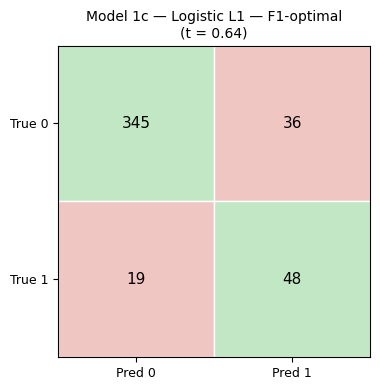

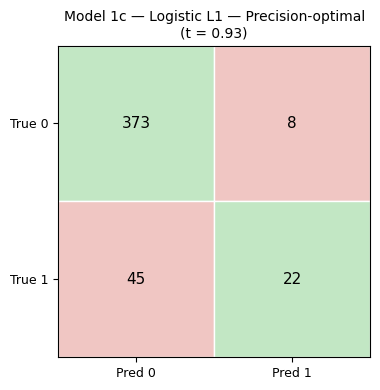

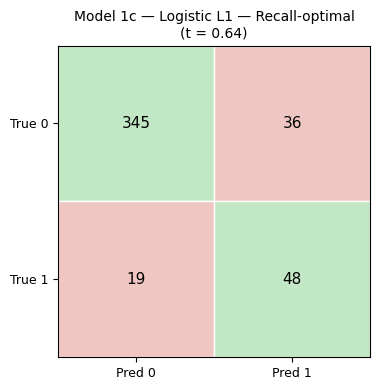


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 — F1-optimal (t=0.64),0.8772,0.5714,0.9055,0.7164,0.6358,0.895,0.639



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 — Precision-optimal (t=...,0.8817,0.7333,0.979,0.3284,0.4536,0.895,0.639



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 — Recall-optimal (t=0.64),0.8772,0.5714,0.9055,0.7164,0.6358,0.895,0.639


In [104]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_1c
model_label  = "Model 1c — Logistic L1"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)

# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


## Model 2 — Support Vector Machines

This section evaluates Support Vector Machine (SVM) classifiers as
margin-based alternatives to logistic regression.

Two variants are considered:
- **Model 2a — Linear SVC**
- **Model 2b — SVC with RBF kernel**

All models use the same preprocessing pipeline and handle class imbalance
via class weighting. Evaluation is performed on the test set at a fixed
threshold of `t = 0.50` prior to threshold optimization.
Probability estimates are enabled for SVM models to allow PR-AUC evaluation and decision threshold optimization.


In [105]:
# ==========================================
# Model 2 — Support Vector Machines (balanced)
#   2a) Linear C
#   2b) SVC with RBF kernel
# ==========================================

from sklearn.svm import SVC

rows = []

# ==================================
# 2a) Linear SVC
# ==================================
pipe_svc_linear = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="linear",
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

pipe_svc_linear.fit(X_train, y_train)

y_pred_2a = pipe_svc_linear.predict(X_test)
y_proba_2a = pipe_svc_linear.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_2a,
        y_proba_2a,
        label="Model 2a — Linear SVC"
    )
)

# ==================================
# 2b) SVC with RBF kernel
# ==================================
pipe_svc_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

pipe_svc_rbf.fit(X_train, y_train)

y_pred_2b = pipe_svc_rbf.predict(X_test)
y_proba_2b = pipe_svc_rbf.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_2b,
        y_proba_2b,
        label="Model 2b — SVC (RBF kernel)"
    )
)

# ==========================================
# Compact comparison table (t = 0.50)
# ==========================================
df_model2_compare = pd.DataFrame(rows)
display(df_model2_compare)


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — Linear SVC,0.799107,0.413534,0.795276,0.820896,0.550000,0.891390,0.616223
1,Model 2b — SVC (RBF kernel),0.843750,0.486957,0.845144,0.835821,0.615385,0.915913,0.687153


### Decision Threshold Optimization (Model 2b)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.431,0.208,0.331,1.00,0.344,0.916,0.687
1,0.02,0.536,0.244,0.454,1.00,0.392,0.916,0.687
2,0.03,0.578,0.258,0.509,0.97,0.408,0.916,0.687
3,0.04,0.627,0.283,0.567,0.97,0.438,0.916,0.687
4,0.05,0.658,0.301,0.604,0.97,0.459,0.916,0.687


F1-optimal threshold: 0.32 (F1-max)
Precision≥0.70 threshold: 0.62 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.33 (recall≥0.7, max precision)


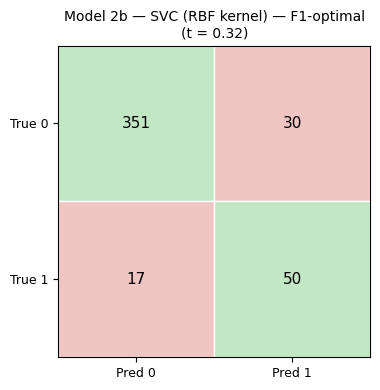

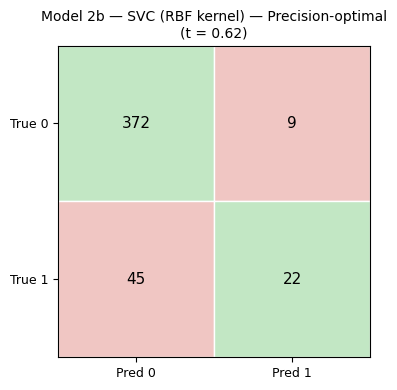

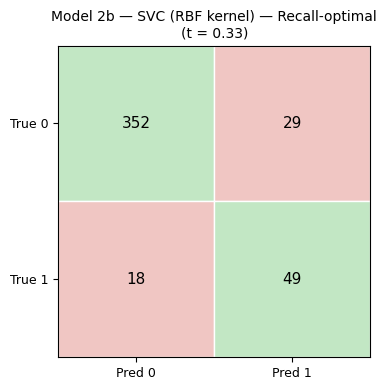


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2b — SVC (RBF kernel) — F1-optimal (t=0.32),0.8951,0.625,0.9213,0.7463,0.6803,0.9159,0.6872



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2b — SVC (RBF kernel) — Precision-optima...,0.8795,0.7097,0.9764,0.3284,0.449,0.9159,0.6872



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2b — SVC (RBF kernel) — Recall-optimal (...,0.8951,0.6282,0.9239,0.7313,0.6759,0.9159,0.6872


In [106]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_2b
model_label  = "Model 2b — SVC (RBF kernel)"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)

# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


## Model 3 — Decision Trees

This section evaluates decision tree classifiers to capture
non-linear relationships and feature interactions.

Three variants are considered:
- **Model 3a — Fully grown tree (no tuning)**
- **Model 3b — Hyperparameter-tuned tree (CV)**
- **Model 3c — Cost-complexity pruned tree (CCP)**

All models use the same preprocessing pipeline and handle class
imbalance via class weighting. Evaluation is performed at a fixed
threshold of `t = 0.50` prior to threshold optimization.


In [34]:
# ==========================================
# Model 3 — Decision Trees (balanced)
#   3a) Full tree (no tuning)
#   3b) Tuned tree (CV)
#   3c) Pruned tree (CCP)
# ==========================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

rows = []

# ==================================
# 3a) Full Decision Tree (no tuning)
# ==================================
pipe_tree_full = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

pipe_tree_full.fit(X_train, y_train)

y_pred_3a = pipe_tree_full.predict(X_test)
y_proba_3a = pipe_tree_full.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_3a,
        y_proba_3a,
        label="Model 3a — Decision Tree (full)"
    )
)

# ==================================
# 3b) Tuned Decision Tree (CV)
# ==================================
param_grid_tree = {
    "classifier__max_depth": [3, 5, 8, 12, None],
    "classifier__min_samples_split": [2, 10, 50],
    "classifier__min_samples_leaf": [1, 5, 20],
}

pipe_tree_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

grid_tree = GridSearchCV(
    pipe_tree_base,
    param_grid=param_grid_tree,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

best_tree_cv = grid_tree.best_estimator_

y_pred_3b = best_tree_cv.predict(X_test)
y_proba_3b = best_tree_cv.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_3b,
        y_proba_3b,
        label="Model 3b — Decision Tree (tuned CV)"
    )
)

# ==================================
# 3c) Decision Tree with CCP pruning
# ==================================

# Transform training data using the fitted preprocessor
X_train_transformed = best_tree_cv.named_steps["preprocessor"].transform(X_train)

path = best_tree_cv.named_steps["classifier"].cost_complexity_pruning_path(
    X_train_transformed,
    y_train
)

ccp_alphas = path.ccp_alphas[:-1]  # drop max alpha

param_grid_ccp = {
    "classifier__ccp_alpha": ccp_alphas
}

grid_ccp = GridSearchCV(
    pipe_tree_base,
    param_grid=param_grid_ccp,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

grid_ccp.fit(X_train, y_train)

best_tree_ccp = grid_ccp.best_estimator_

y_pred_3c = best_tree_ccp.predict(X_test)
y_proba_3c = best_tree_ccp.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_3c,
        y_proba_3c,
        label="Model 3c — Decision Tree (CCP pruned)"
    )
)

# ==========================================
# Compact comparison table (t = 0.50)
# ==========================================
df_model3_compare = pd.DataFrame(rows)
display(df_model3_compare)


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Decision Tree (full),0.814732,0.397436,0.876640,0.462687,0.427586,0.671779,0.470192
1,Model 3b — Decision Tree (tuned CV),0.727679,0.317881,0.729659,0.716418,0.440367,0.832393,0.551783
2,Model 3c — Decision Tree (CCP pruned),0.741071,0.333333,0.742782,0.731343,0.457944,0.801034,0.386766


### Decision Threshold Optimization (Model 3b)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.618,0.27,0.567,0.91,0.416,0.832,0.552
1,0.02,0.618,0.27,0.567,0.91,0.416,0.832,0.552
2,0.03,0.618,0.27,0.567,0.91,0.416,0.832,0.552
3,0.04,0.618,0.27,0.567,0.91,0.416,0.832,0.552
4,0.05,0.618,0.27,0.567,0.91,0.416,0.832,0.552


F1-optimal threshold: 0.75 (F1-max)
Precision≥0.70 threshold: 0.91 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.63 (recall≥0.7, max precision)


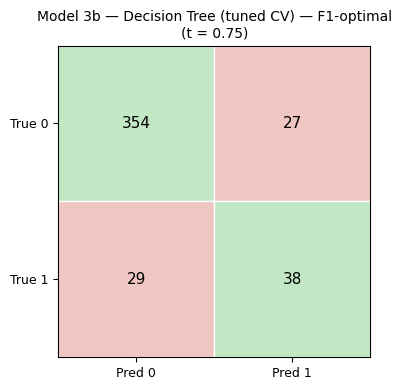

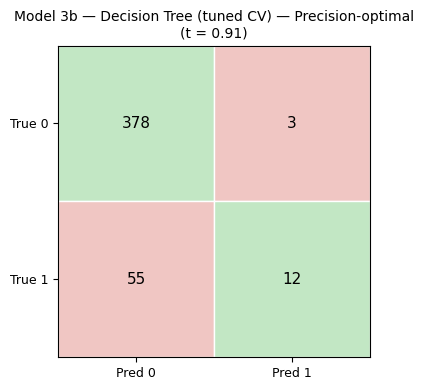

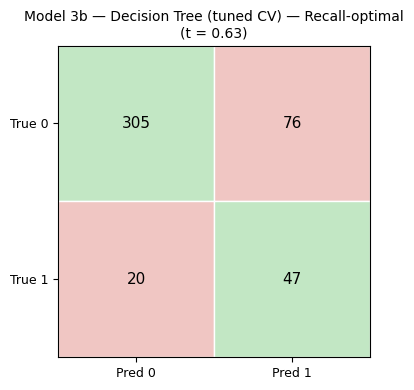


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — Decision Tree (tuned CV) — F1-optim...,0.875,0.5846,0.9291,0.5672,0.5758,0.8324,0.5518



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — Decision Tree (tuned CV) — Precisio...,0.8705,0.8,0.9921,0.1791,0.2927,0.8324,0.5518



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — Decision Tree (tuned CV) — Recall-o...,0.7857,0.3821,0.8005,0.7015,0.4947,0.8324,0.5518


In [107]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_3b
model_label  = "Model 3b — Decision Tree (tuned CV)"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)

# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


## Model 4 — Random Forest

This section evaluates Random Forest classifiers as ensemble-based,
non-linear models.

Two variants are considered:
- **Model 4a — Baseline Random Forest**
- **Model 4b — Fast-tuned Random Forest (CV)**

Evaluation is performed at a fixed threshold of `t = 0.50` prior to
decision threshold optimization.


In [36]:
# ==========================================
# Model 4 — Random Forest (balanced)
#   4a) Baseline Random Forest
#   4b) Fast-tuned Random Forest (CV)
# ==========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rows = []

# ==================================
# 4a) Random Forest — Baseline
# ==================================
pipe_rf_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe_rf_base.fit(X_train, y_train)

y_pred_4a = pipe_rf_base.predict(X_test)
y_proba_4a = pipe_rf_base.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_4a,
        y_proba_4a,
        label="Model 4a — Random Forest (baseline)"
    )
)

# ==================================
# 4b) Random Forest — Fast tuning (CV)
# ==================================
param_grid_rf = {
    "classifier__n_estimators": [300, 500],
    "classifier__max_depth": [None, 8, 15],
    "classifier__min_samples_leaf": [1, 5, 20],
}

pipe_rf_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

grid_rf = GridSearchCV(
    pipe_rf_tuned,
    param_grid=param_grid_rf,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

y_pred_4b = best_rf.predict(X_test)
y_proba_4b = best_rf.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_4b,
        y_proba_4b,
        label="Model 4b — Random Forest (fast tuned)"
    )
)

# ==========================================
# Compact comparison table (t = 0.50)
# ==========================================
df_model4_compare = pd.DataFrame(rows)
display(df_model4_compare)


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4a — Random Forest (baseline),0.888393,0.757576,0.979003,0.373134,0.500000,0.899557,0.622989
1,Model 4b — Random Forest (fast tuned),0.872768,0.564103,0.910761,0.656716,0.606897,0.905375,0.660393


### Decision Threshold Optimization (Model 4b)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.170,0.153,0.024,1.0,0.265,0.905,0.66
1,0.02,0.190,0.156,0.047,1.0,0.270,0.905,0.66
2,0.03,0.219,0.161,0.081,1.0,0.277,0.905,0.66
3,0.04,0.263,0.169,0.134,1.0,0.289,0.905,0.66
4,0.05,0.304,0.177,0.181,1.0,0.300,0.905,0.66


F1-optimal threshold: 0.47 (F1-max)
Precision≥0.70 threshold: 0.58 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.47 (recall≥0.7, max precision)


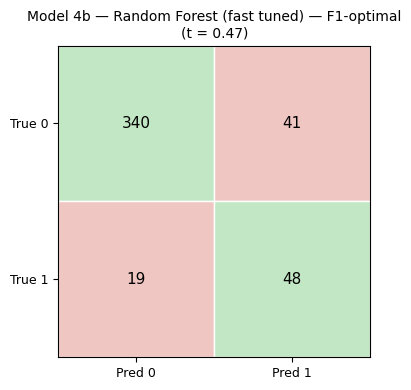

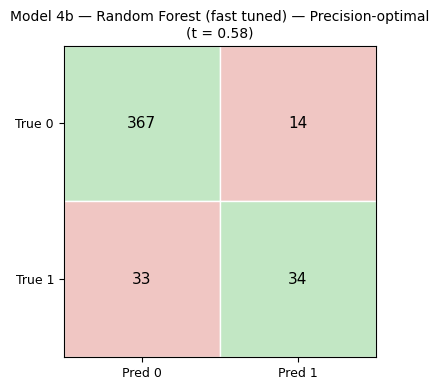

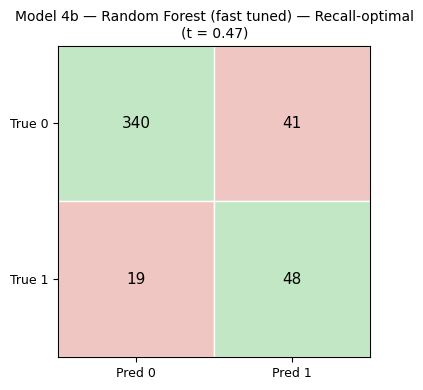


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4b — Random Forest (fast tuned) — F1-opt...,0.8661,0.5393,0.8924,0.7164,0.6154,0.9054,0.6604



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4b — Random Forest (fast tuned) — Precis...,0.8951,0.7083,0.9633,0.5075,0.5913,0.9054,0.6604



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4b — Random Forest (fast tuned) — Recall...,0.8661,0.5393,0.8924,0.7164,0.6154,0.9054,0.6604


In [108]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_4b
model_label  = "Model 4b — Random Forest (fast tuned)"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)

# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


## Model 5 — Boosting Models

This section evaluates boosting-based classifiers that sequentially
combine weak learners to improve predictive performance.

Two variants are considered:
- **Model 5a — Gradient Boosting**
- **Model 5b — XGBoost (fast tuned)**

All models are evaluated at a fixed threshold of `t = 0.50` prior to
decision threshold optimization.

In [39]:
# ==========================================
# Model 5 — Boosting Models
#   5a) Gradient Boosting (baseline)
#   5b) XGBoost (fast tuned)
# ==========================================

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

rows = []

# ==================================
# 5a) Gradient Boosting — Baseline
# ==================================
pipe_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ))
])

pipe_gb.fit(X_train, y_train)

y_pred_5a = pipe_gb.predict(X_test)
y_proba_5a = pipe_gb.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_5a,
        y_proba_5a,
        label="Model 5a — Gradient Boosting"
    )
)

# ==================================
# 5b) XGBoost — Fast tuning (CV)
# ==================================
pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        #use_label_encoder=False,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    ))
])

param_grid_xgb = {
    "classifier__n_estimators": [300, 500],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0],
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    scoring="average_precision",
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_

y_pred_5b = best_xgb.predict(X_test)
y_proba_5b = best_xgb.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_5b,
        y_proba_5b,
        label="Model 5b — XGBoost (fast tuned)"
    )
)

# ==========================================
# Compact comparison table (t = 0.50)
# ==========================================
df_model5_compare = pd.DataFrame(rows)
display(df_model5_compare)


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5a — Gradient Boosting,0.895089,0.777778,0.979003,0.417910,0.543689,0.902672,0.650948
1,Model 5b — XGBoost (fast tuned),0.854911,0.509615,0.866142,0.791045,0.619883,0.913327,0.699890


### Decision Threshold Optimization (Model 5b)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.290,0.174,0.165,1.0,0.296,0.913,0.7
1,0.02,0.353,0.188,0.239,1.0,0.316,0.913,0.7
2,0.03,0.417,0.204,0.315,1.0,0.339,0.913,0.7
3,0.04,0.462,0.218,0.367,1.0,0.357,0.913,0.7
4,0.05,0.504,0.232,0.417,1.0,0.376,0.913,0.7


F1-optimal threshold: 0.72 (F1-max)
Precision≥0.70 threshold: 0.71 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.55 (recall≥0.7, max precision)


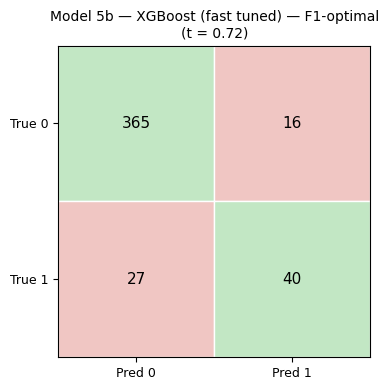

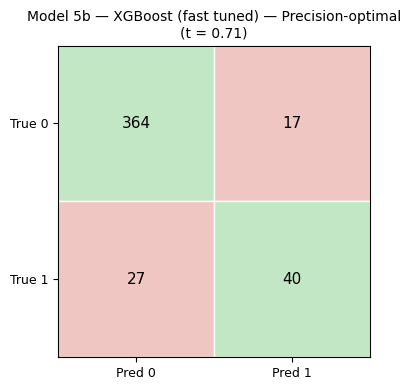

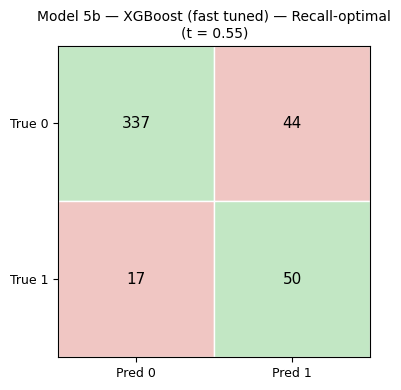


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — XGBoost (fast tuned) — F1-optimal (...,0.904,0.7143,0.958,0.597,0.6504,0.9133,0.6999



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — XGBoost (fast tuned) — Precision-op...,0.9018,0.7018,0.9554,0.597,0.6452,0.9133,0.6999



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — XGBoost (fast tuned) — Recall-optim...,0.8638,0.5319,0.8845,0.7463,0.6211,0.9133,0.6999


In [109]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_5b
model_label  = "Model 5b — XGBoost (fast tuned)"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)

# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


In [110]:
# ==========================================
# Final Model Comparison — PR-AUC ranking
# with soft family highlighting
# ==========================================

# 1) Combine all model comparison tables
dfs = [
    df_model1_compare,
    df_model2_compare,
    df_model3_compare,
    df_model4_compare,
    df_model5_compare,
]

df_all_models = pd.concat(dfs, ignore_index=True)

# 2) Rank by PR-AUC
df_ranked = (
    df_all_models[
        ["model", "pr_auc", "roc_auc"]
    ]
    .sort_values(by="pr_auc", ascending=False)
    .reset_index(drop=True)
)

# 3) Assign model family
def extract_family(model_name):
    if model_name.startswith("Model 1"):
        return "Logistic"
    if model_name.startswith("Model 2"):
        return "SVM"
    if model_name.startswith("Model 3"):
        return "Decision Tree"
    if model_name.startswith("Model 4"):
        return "Random Forest"
    if model_name.startswith("Model 5"):
        return "Boosting"
    return "Other"

df_ranked["Family"] = df_ranked["model"].apply(extract_family)

# 4) Define soft background colors per family
family_colors = {
    "Logistic":      "#F3E5F5",  # light purple
    "SVM":           "#E3F2FD",  # light blue
    "Decision Tree": "#E8F5E9",  # light green
    "Random Forest": "#FFFDE7",  # light yellow
    "Boosting":      "#FBE9E7",  # light orange
}

def highlight_family(row):
    color = family_colors.get(row["Family"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)

# 5) Styled display
styled_df = (
    df_ranked
    .style
    .apply(highlight_family, axis=1)
    .format({
        "pr_auc": "{:.3f}",
        "roc_auc": "{:.3f}",
        "f1": "{:.3f}",
        "precision": "{:.3f}",
        "recall": "{:.3f}",
    })
)

display(styled_df)


,model,pr_auc,roc_auc,Family
0,Model 5b — XGBoost (fast tuned),0.700,0.913,Boosting
1,Model 2b — SVC (RBF kernel),0.687,0.916,SVM
2,Model 4b — Random Forest (fast tuned),0.660,0.905,Random Forest
3,Model 5a — Gradient Boosting,0.651,0.903,Boosting
4,"Model 1c — Logistic L1 (balanced, CV)",0.639,0.895,Logistic
5,"Model 1b — Logistic L2 (balanced, CV)",0.636,0.895,Logistic
6,"Model 1a — Logistic (balanced, no CV)",0.635,0.895,Logistic
7,Model 4a — Random Forest (baseline),0.623,0.900,Random Forest
8,Model 2a — Linear SVC,0.616,0.891,SVM
9,Model 3b — Decision Tree (tuned CV),0.552,0.832,Decision Tree


In [115]:
# ==========================================
# Final Model Comparison — PR-AUC ranking
# with soft family highlighting
# ==========================================

# 1) Combine all model comparison tables
dfs = [
    df_model1_compare,
    df_model2_compare,
    df_model3_compare,
    df_model4_compare,
    df_model5_compare,
]

df_all_models = pd.concat(dfs, ignore_index=True)

# 2) Rank by PR-AUC
df_ranked = (
    df_all_models[
        ["model", "pr_auc", "roc_auc"]
    ]
    .sort_values(by="pr_auc", ascending=False)
    .reset_index(drop=True)
)

# 3) Assign model family
def extract_family(model_name):
    if model_name.startswith("Model 1"):
        return "Logistic"
    if model_name.startswith("Model 2"):
        return "SVM"
    if model_name.startswith("Model 3"):
        return "Decision Tree"
    if model_name.startswith("Model 4"):
        return "Random Forest"
    if model_name.startswith("Model 5"):
        return "Boosting"
    return "Other"

df_ranked["Family"] = df_ranked["model"].apply(extract_family)

# 4) Define soft background colors per family
family_icon = {
    "Logistic": "🟣",
    "SVM": "🔵 ",
    "Decision Tree": "🟢",
    "Random Forest": "🟡",
    "Boosting": "🟠",
}

df_ranked["FamilyTag"] = df_ranked["Family"].map(family_icon).fillna("⬜")
display(df_ranked[["FamilyTag","Family","model","pr_auc","roc_auc"]])
# 5) Styled display
styled_df = (
    df_ranked
    .style
    .apply(highlight_family, axis=1)
    .format({
        "pr_auc": "{:.3f}",
        "roc_auc": "{:.3f}",
        "f1": "{:.3f}",
        "precision": "{:.3f}",
        "recall": "{:.3f}",
    })
)       


,FamilyTag,Family,model,pr_auc,roc_auc
0,🟠,Boosting,Model 5b — XGBoost (fast tuned),0.699890,0.913327
1,🔵,SVM,Model 2b — SVC (RBF kernel),0.687153,0.915913
2,🟡,Random Forest,Model 4b — Random Forest (fast tuned),0.660393,0.905375
3,🟠,Boosting,Model 5a — Gradient Boosting,0.650948,0.902672
4,🟣,Logistic,"Model 1c — Logistic L1 (balanced, CV)",0.638959,0.895033
5,🟣,Logistic,"Model 1b — Logistic L2 (balanced, CV)",0.636408,0.895033
6,🟣,Logistic,"Model 1a — Logistic (balanced, no CV)",0.635181,0.894798
7,🟡,Random Forest,Model 4a — Random Forest (baseline),0.622989,0.899557
8,🔵,SVM,Model 2a — Linear SVC,0.616223,0.891390
9,🟢,Decision Tree,Model 3b — Decision Tree (tuned CV),0.551783,0.832393
